# Cyber Bullying Classification 

## Goal: 

In [1]:
# Foundational Libraries
import pandas as pd 
import numpy as np 

# All Text Pre-Proccessing Libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.tokenize import word_tokenize
import string

from tqdm import tqdm # For Progress
import concurrent.futures


# Read in Dataset
df = pd.read_csv('cyberbullying_tweets.csv')
print(df.info)


<bound method DataFrame.info of                                               tweet_text cyberbullying_type
0      In other words #katandandre, your food was cra...  not_cyberbullying
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
...                                                  ...                ...
47687  Black ppl aren't expected to do anything, depe...          ethnicity
47688  Turner did not withhold his disappointment. Tu...          ethnicity
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity

[47692 rows x 2 columns]>


Taken below code from: 
https://github.com/NumericCamel/Crypto/blob/main/scripts/sentiment_analyzer.py

In [2]:
blacklist = []
# Ensure nltk resources are downloaded
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize stopwords and SentimentIntensityAnalyzer
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuationaa
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text using spaCy's nlp pipeline
    tokens = nlp(text)
    
    # Remove stop words and non-alphabetic tokens, and perform lemmatization
    tokens = [token.lemma_ for token in tokens if token.is_alpha and token.text not in stop_words and token.text not in blacklist]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [3]:
def apply_preprocessing(df):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Submit all jobs, storing futures along with the index to preserve order
        futures = {executor.submit(preprocess_text, text): index for index, text in enumerate(df['tweet_text'])}
        results = [None] * len(df)  # Create a results list of the correct size

        # As each future completes, place the result in the correct position
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Text"):
            index = futures[future]  # Get the original index
            results[index] = future.result()
    
    # Create a new DataFrame with the results
    processed_df = df.copy()
    processed_df['preprocessed_text'] = results
    return processed_df

In [4]:
thous_df = df.sample(n=1000)
thous_df.tail(3)

,tweet_text,cyberbullying_type
22761,Says the @VP who blatantly lies to support his...,religion
7738,@d99radio Manrriquez cuando sufres de bulling ...,not_cyberbullying
10920,amazes me any1 wld vote 4 frankie who claims 2...,gender


In [5]:
thous_df['Processed-Text'] = thous_df['tweet_text'].apply(preprocess_text)

I have made a wordcloud below. Anyword that is big, is also mentioned more. 

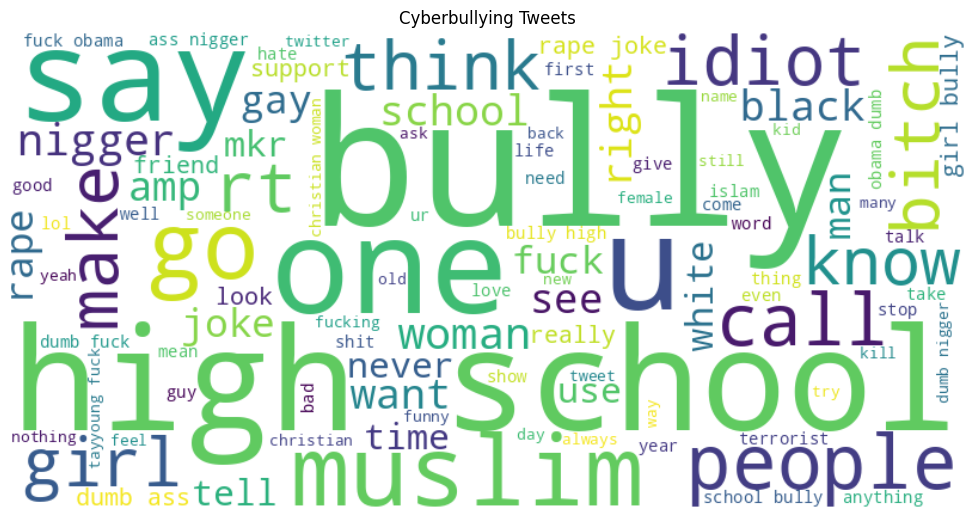

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all processed texts
text = " ".join(review for review in thous_df['Processed-Text'])

# Create WordCloud object
wordcloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    #stopwords=STOPWORDS,
    max_font_size=150,
    max_words=100
).generate(text)

# Display the generated image
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Cyberbullying Tweets')
plt.tight_layout(pad=0)
plt.show()

### Now let us make a TF-IDF 

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It is widely used in information retrieval and text mining to identify significant words and filter out common words that may not be useful for distinguishing documents.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
TFIDF = vectorizer.fit_transform(thous_df['Processed-Text'])

TFIDF_df = pd.DataFrame(TFIDF.toarray(), columns=vectorizer.get_feature_names_out())
# Sum the TF-IDF values for each word (column)
TFIDF_df = TFIDF_df.sum().sort_values(ascending=False)

# Reorder the columns based on the sorted sums
TFIDF_df = TFIDF_df[TFIDF_df.index]

#Let's print the result 
print(TFIDF_df)

bully      34.992592
school     30.295825
fuck       25.905254
dumb       23.003122
nigger     21.990690
             ...    
bt          0.187948
rouge       0.184965
pok         0.184965
patient     0.184965
blot        0.184965
Length: 3921, dtype: float64


Another intesting method are bi-grams. Which 2 words happen the most frequenlty consecuively? 

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer instance for bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the text data
bigram_matrix = vectorizer.fit_transform(thous_df['Processed-Text'])

# Get the bigrams
bigram_features = vectorizer.get_feature_names_out()

# Convert the bigram matrix to a DataFrame for easier viewing
bigram_df = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_features)

# Sum the occurrences of each bigram
bigram_sums = bigram_df.sum().sort_values(ascending=False)

# Display the sorted bigrams and their counts
sorted_bigrams_df = pd.DataFrame(bigram_sums, columns=['Count'])
print(sorted_bigrams_df)

               Count
high school      108
rape joke         36
girl bully        36
dumb ass          35
bully high        35
...              ...
go troll           1
go ur              1
go viral           1
go wanna           1
үou something      1

[10426 rows x 1 columns]


RAKE (Rapid Automatic Keyword Extraction) is an algorithm designed to identify the most relevant keywords or key phrases in a piece of text. It is an unsupervised, domain-independent method, meaning it does not require training on labeled data and can be applied to any text regardless of the domain. RAKE is particularly useful for tasks like summarization, indexing, and information retrieval, where identifying significant words or phrases is crucial.

In [33]:
from rake_nltk import Rake

# Initialize RAKE
rake = Rake()

# Function to extract keywords from a single text entry
def extract_keywords(text):
    rake.extract_keywords_from_text(text)
    return rake.get_ranked_phrases()

# Apply the function to the DataFrame column
thous_df['keywords'] = thous_df['Processed-Text'].apply(extract_keywords)

# Display the DataFrame with the extracted keywords
print(thous_df)

                                              tweet_text   cyberbullying_type  \
24081     @Sher_adelelee Wad happen ? Who bully you ? :(  other_cyberbullying   
33231  This girl I went to high school with bullied m...                  age   
14391  Just because queer people exist in media and a...               gender   
43583  RT @shebad32 “@tayyoung_: FUCK OBAMA, dumb ass...            ethnicity   
38748  How about we just focus on the big one. You kn...                  age   
...                                                  ...                  ...   
23730  Mashallah You r in support of Hindusthani-Musl...             religion   
15840  Anti-feminist YouTuber doubles down on vile Je...               gender   
22761  Says the @VP who blatantly lies to support his...             religion   
7738   @d99radio Manrriquez cuando sufres de bulling ...    not_cyberbullying   
10920  amazes me any1 wld vote 4 frankie who claims 2...               gender   

                           